# pvlib-Python Forecasting (Denver, CO)
### Install Standard Release 

In [1]:
!pip install --upgrade pip

Requirement already up-to-date: pip in /home/nbuser/anaconda3_501/lib/python3.6/site-packages (20.1)


In [2]:
# Package from the Python Package Index
!pip install pvlib

# Module netCDF4 was not found 
!pip install netCDF4

# Module siphon was not found
!pip install siphon

# 4/20/2020: version 1.1.2 released. Code optimization, fix logic so only_use_cftime_datimes=False works as expected (issues #158 and #165). 
!pip install cftime==1.1.2


# Try to save Excel
!pip install openpyxl

In [3]:
# Make basic imports and then set the location and time range data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pytz
import seaborn as sns; sns.set_color_codes()
import datetime

# Import pvlib forecast models
from pvlib.forecast import GFS, NAM, NDFD, HRRR, RAP
from pvlib import solarposition
from pvlib.location import Location
from matplotlib.pyplot import figure
%matplotlib inline

# Specify Location (Albuiquerque, NM)
latitude, longitude, tz = 39.7, -105.2, 'US/Mountain'

# Specify time range
start = pd.Timestamp(datetime.date.today(), tz=tz)
end = start + pd.Timedelta(days=4)
irrad_vars = ['ghi','dni','dhi']

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/pvlib/forecast.py:19: UserWarning: The forecast module algorithms and features are highly experimental. The API may change, the functionality may be consolidated into an io module, or the module may be separated into its own package.
  'The forecast module algorithms and features are highly experimental. '


In [4]:
pytz.all_timezones

['Africa/Abidjan',
 'Africa/Accra',
 'Africa/Addis_Ababa',
 'Africa/Algiers',
 'Africa/Asmara',
 'Africa/Asmera',
 'Africa/Bamako',
 'Africa/Bangui',
 'Africa/Banjul',
 'Africa/Bissau',
 'Africa/Blantyre',
 'Africa/Brazzaville',
 'Africa/Bujumbura',
 'Africa/Cairo',
 'Africa/Casablanca',
 'Africa/Ceuta',
 'Africa/Conakry',
 'Africa/Dakar',
 'Africa/Dar_es_Salaam',
 'Africa/Djibouti',
 'Africa/Douala',
 'Africa/El_Aaiun',
 'Africa/Freetown',
 'Africa/Gaborone',
 'Africa/Harare',
 'Africa/Johannesburg',
 'Africa/Juba',
 'Africa/Kampala',
 'Africa/Khartoum',
 'Africa/Kigali',
 'Africa/Kinshasa',
 'Africa/Lagos',
 'Africa/Libreville',
 'Africa/Lome',
 'Africa/Luanda',
 'Africa/Lubumbashi',
 'Africa/Lusaka',
 'Africa/Malabo',
 'Africa/Maputo',
 'Africa/Maseru',
 'Africa/Mbabane',
 'Africa/Mogadishu',
 'Africa/Monrovia',
 'Africa/Nairobi',
 'Africa/Ndjamena',
 'Africa/Niamey',
 'Africa/Nouakchott',
 'Africa/Ouagadougou',
 'Africa/Porto-Novo',
 'Africa/Sao_Tome',
 'Africa/Timbuktu',
 'Africa/

In [5]:
pytz.country_timezones('US')

['America/New_York',
 'America/Detroit',
 'America/Kentucky/Louisville',
 'America/Kentucky/Monticello',
 'America/Indiana/Indianapolis',
 'America/Indiana/Vincennes',
 'America/Indiana/Winamac',
 'America/Indiana/Marengo',
 'America/Indiana/Petersburg',
 'America/Indiana/Vevay',
 'America/Chicago',
 'America/Indiana/Tell_City',
 'America/Indiana/Knox',
 'America/Menominee',
 'America/North_Dakota/Center',
 'America/North_Dakota/New_Salem',
 'America/North_Dakota/Beulah',
 'America/Denver',
 'America/Boise',
 'America/Phoenix',
 'America/Los_Angeles',
 'America/Anchorage',
 'America/Juneau',
 'America/Sitka',
 'America/Metlakatla',
 'America/Yakutat',
 'America/Nome',
 'America/Adak',
 'Pacific/Honolulu']

In [6]:
# GFS model, defaults to 0.5 degree resolution
# 0.25 deg available 
model = GFS() 

# Retrive data.returns panda.DataFrame object
raw_data = model.get_data(latitude, longitude, start, end)
print(raw_data.head())

                           Total_cloud_cover_low_cloud_Mixed_intervals_Average  \
2020-05-11 06:00:00-06:00                                                1.0     
2020-05-11 09:00:00-06:00                                                0.0     
2020-05-11 12:00:00-06:00                                                0.0     
2020-05-11 15:00:00-06:00                                                1.0     
2020-05-11 18:00:00-06:00                                                6.0     

                           Downward_Short-Wave_Radiation_Flux_surface_Mixed_intervals_Average  \
2020-05-11 06:00:00-06:00                                               51.0                    
2020-05-11 09:00:00-06:00                                                0.0                    
2020-05-11 12:00:00-06:00                                                0.0                    
2020-05-11 15:00:00-06:00                                              130.0                    
2020-05-11 18:00:00-06

### Process Data with pvlib

In [7]:
# Process this data before using it with pvlib
data = raw_data

# Rename the columns according the key/value pairs in model.variables.
data = model.rename(data)

# Convert temperature
data['temp_air'] = model.kelvin_to_celsius(data['temp_air'])

# Convert wind components to wind speed
data['wind_speed'] = model.uv_to_speed(data)

# Calculate irradiance estimates from cloud cover.
irrad_data = model.cloud_cover_to_irradiance(data['total_clouds'])
data = data.join(irrad_data, how='outer')

# Keep only the final data
data = data[model.output_variables]

print(data.head())

                            temp_air  wind_speed         ghi        dni  \
2020-05-11 06:00:00-06:00   3.717529    4.308022    0.598209   0.000000   
2020-05-11 09:00:00-06:00   2.649994    3.179159  209.850789  15.980416   
2020-05-11 12:00:00-06:00   1.550018    3.271343  339.170357  20.145166   
2020-05-11 15:00:00-06:00   8.659027    1.986788  278.466142  14.664176   
2020-05-11 18:00:00-06:00  16.893799    2.623464  102.699955   0.000000   

                                  dhi  total_clouds  low_clouds  mid_clouds  \
2020-05-11 06:00:00-06:00    0.598209          24.0         1.0        23.0   
2020-05-11 09:00:00-06:00  200.711607          90.0         0.0        34.0   
2020-05-11 12:00:00-06:00  320.891513          95.0         0.0        46.0   
2020-05-11 15:00:00-06:00  266.329091         100.0         1.0        97.0   
2020-05-11 18:00:00-06:00  102.699955         100.0         6.0        98.0   

                           high_clouds  
2020-05-11 06:00:00-06:00        

### GFS'S Class

In [8]:
# process_data method combines these steps in a single function
data = model.process_data(raw_data)
print(data.head())

# Implement their own process_data methods on inherited classes or implement similar stand-alone functions
# Also implement a get_processed_data() method that combines the get_data() and process_data() calls
data = model.get_processed_data(latitude, longitude, start, end)
print(data.head())

                            temp_air  wind_speed         ghi        dni  \
2020-05-11 06:00:00-06:00   3.717529    4.308022    0.598209   0.000000   
2020-05-11 09:00:00-06:00   2.649994    3.179159  209.850789  15.980416   
2020-05-11 12:00:00-06:00   1.550018    3.271343  339.170357  20.145166   
2020-05-11 15:00:00-06:00   8.659027    1.986788  278.466142  14.664176   
2020-05-11 18:00:00-06:00  16.893799    2.623464  102.699955   0.000000   

                                  dhi  total_clouds  low_clouds  mid_clouds  \
2020-05-11 06:00:00-06:00    0.598209          24.0         1.0        23.0   
2020-05-11 09:00:00-06:00  200.711607          90.0         0.0        34.0   
2020-05-11 12:00:00-06:00  320.891513          95.0         0.0        46.0   
2020-05-11 15:00:00-06:00  266.329091         100.0         1.0        97.0   
2020-05-11 18:00:00-06:00  102.699955         100.0         6.0        98.0   

                           high_clouds  
2020-05-11 06:00:00-06:00        

## Cloud Cover & Radiation

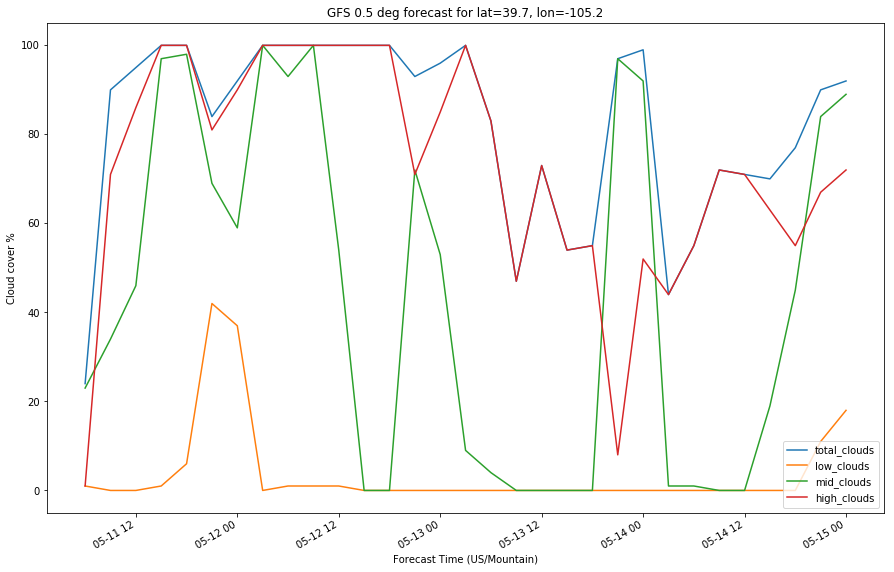

In [9]:
# Plot cloud cover percentages
cloud_vars = ['total_clouds', 'low_clouds','mid_clouds', 'high_clouds']
data[cloud_vars].plot(figsize=(15,10));
plt.ylabel('Cloud cover %');
plt.xlabel('Forecast Time ({})'.format(tz));
plt.title('GFS 0.5 deg forecast for lat={}, lon={}'.format(latitude, longitude));
plt.legend();

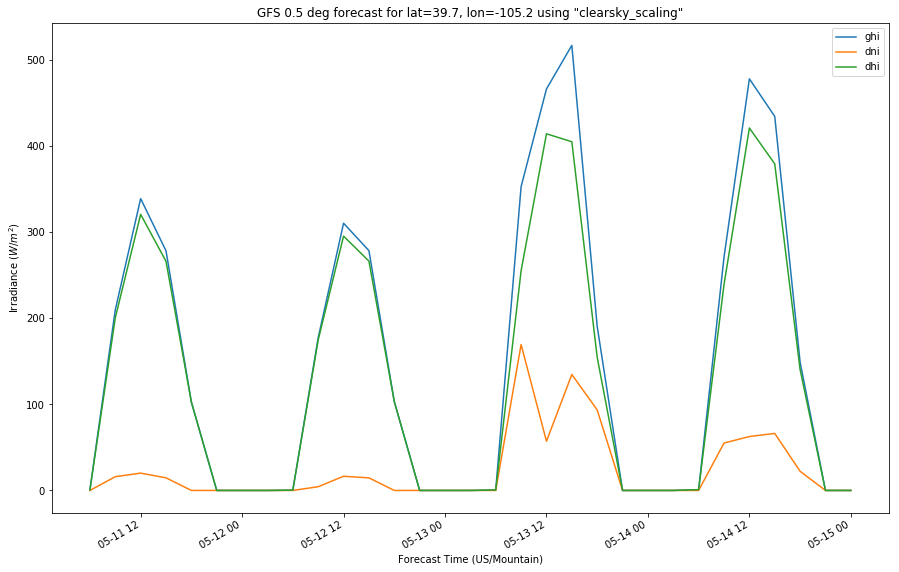

In [10]:
# Plot irradiance data
data = model.rename(raw_data)
irrads = model.cloud_cover_to_irradiance(data['total_clouds'], how='clearsky_scaling')
irrads.plot(figsize=(15,10));
plt.ylabel('Irradiance ($W/m^2$)');
plt.xlabel('Forecast Time ({})'.format(tz));
plt.title('GFS 0.5 deg forecast for lat={}, lon={} using "clearsky_scaling"'.format(latitude, longitude));
plt.legend();

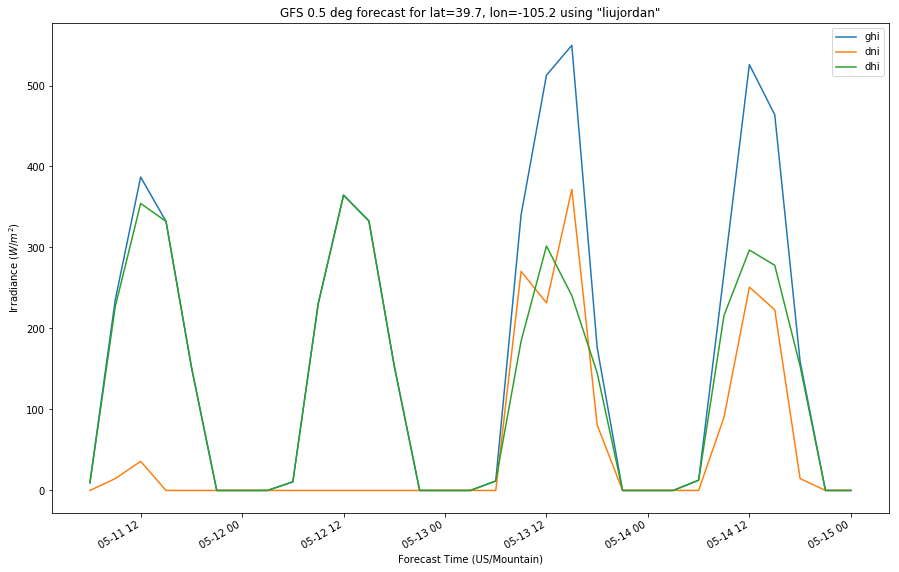

In [11]:
# Plot irradiance data
# Irradiance forecast one hour resolution as the weather data
irrads = model.cloud_cover_to_irradiance(data['total_clouds'], how='liujordan')
irrads.plot(figsize=(15,10));
plt.ylabel('Irradiance ($W/m^2$)');
plt.xlabel('Forecast Time ({})'.format(tz));
plt.title('GFS 0.5 deg forecast for lat={}, lon={} using "liujordan"'.format(latitude, longitude));
plt.legend();

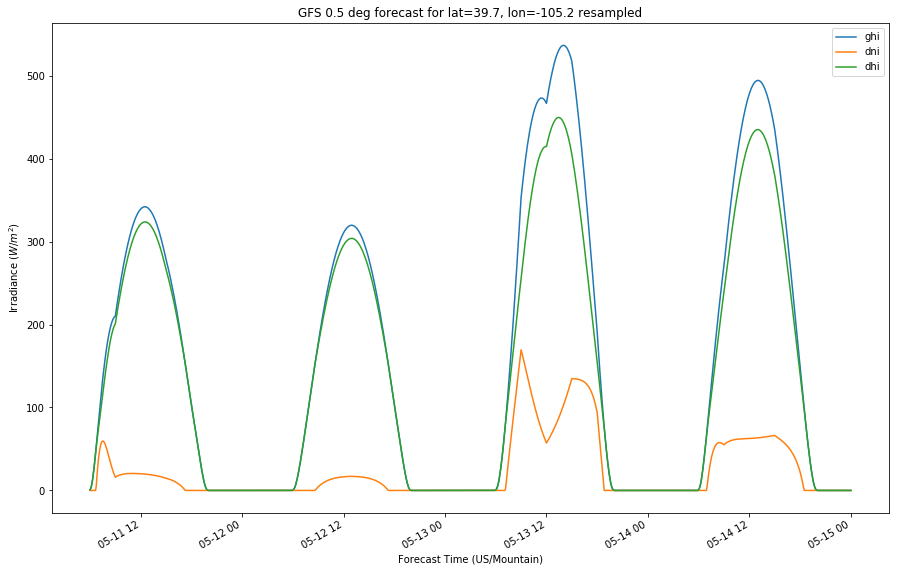

In [12]:
# Five min data resample
resampled_data = data.resample('5min').interpolate()
resampled_irrads = model.cloud_cover_to_irradiance(resampled_data['total_clouds'], how='clearsky_scaling')
resampled_irrads.plot(figsize=(15,10));
plt.ylabel('Irradiance ($W/m^2$)');
plt.xlabel('Forecast Time ({})'.format(tz));
plt.title('GFS 0.5 deg forecast for lat={}, lon={} resampled'.format(latitude,longitude));
plt.legend();

## Weather Models
### GFS
- The Global Forecast System is the US model that provides forecast for the entire globe (6hr update)
### HRRR

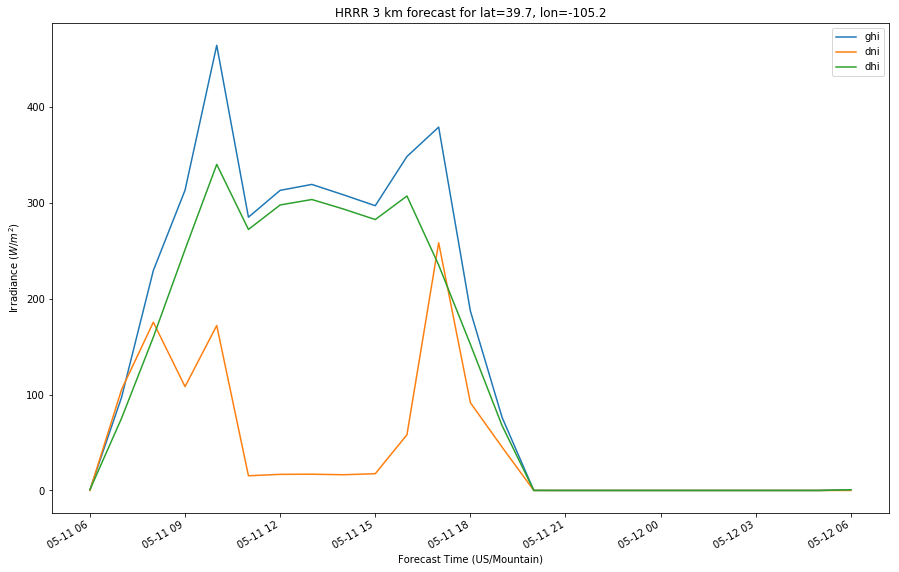

In [13]:
# High Resolution Rapid Refresh most accurate
# Only available for 15 hours
model = HRRR()
data = model.get_processed_data(latitude, longitude, start, end)
data[irrad_vars].plot(figsize=(15,10));
plt.ylabel('Irradiance ($W/m^2$)');
plt.xlabel('Forecast Time ({})'.format(tz));
plt.title('HRRR 3 km forecast for lat={}, lon={}'.format(latitude, longitude));
plt.legend();

### RAP

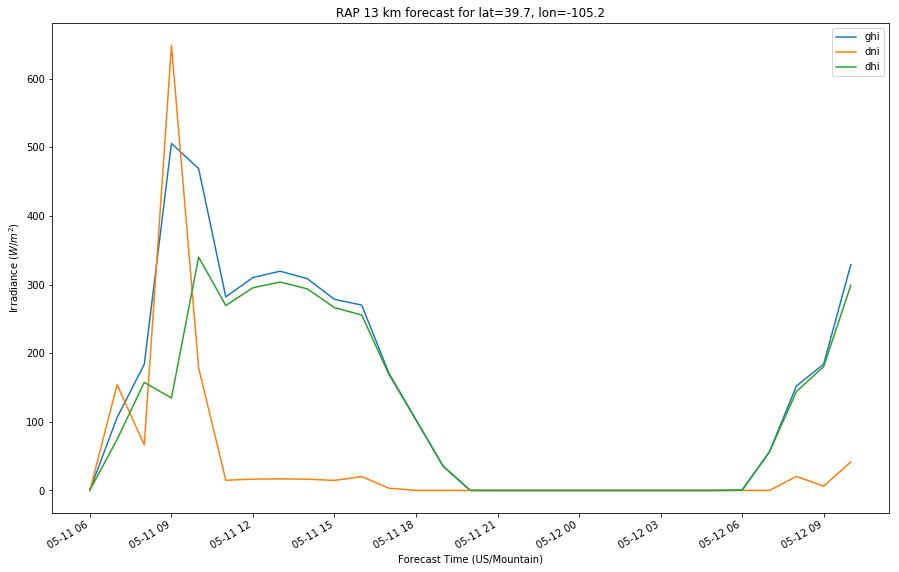

In [14]:
# The Rapid Refresh model is the parent model for the HRRR
# Updated every hour with a 20, 40 km resolution
model = RAP()
data = model.get_processed_data(latitude, longitude, start, end)
data[irrad_vars].plot(figsize=(15,10));
plt.ylabel('Irradiance ($W/m^2$)');
plt.xlabel('Forecast Time ({})'.format(tz));
plt.title('RAP 13 km forecast for lat={}, lon={}'.format(latitude, longitude));
plt.legend();

### NDFD

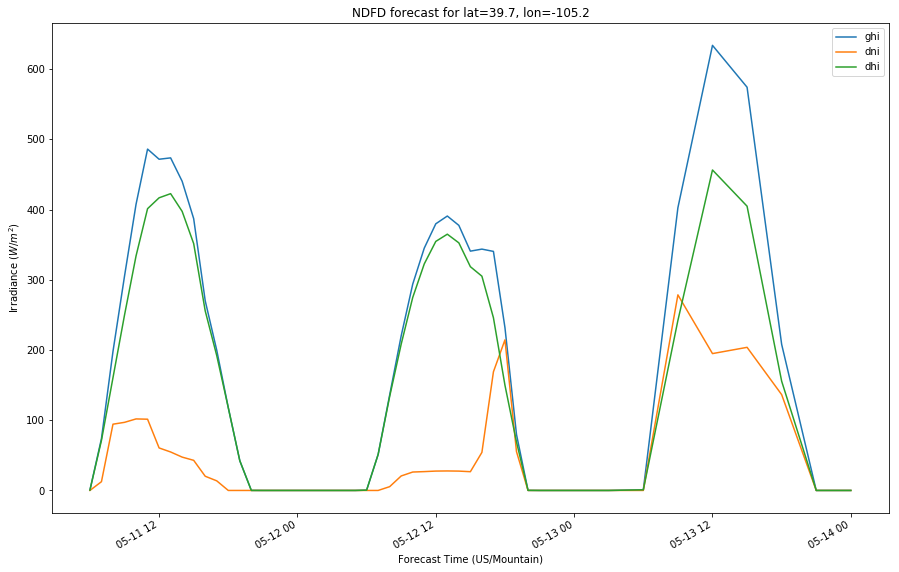

In [15]:
# The National Digital Forecast Database is not a model
# Is a collection of forecasts made by National Weather Service offices accross the country
# Updated every six hours
# Only available for the US
model = NDFD()
data = model.get_processed_data(latitude, longitude, start, end)
data[irrad_vars].plot(figsize=(15,10));
plt.ylabel('Irradiance ($W/m^2$)');
plt.xlabel('Forecast Time ({})'.format(tz));
plt.title('NDFD forecast for lat={}, lon={}'.format(latitude, longitude));
plt.legend();

# PV Power Forecast

In [16]:
from pvlib.pvsystem import PVSystem, retrieve_sam
from pvlib.temperature import TEMPERATURE_MODEL_PARAMETERS
from pvlib.tracking import SingleAxisTracker
from pvlib.modelchain import ModelChain

sandia_modules = retrieve_sam('sandiamod')
cec_inverters = retrieve_sam('cecinverter')
module = sandia_modules['Canadian_Solar_CS5P_220M___2009_']
inverter = cec_inverters['SMA_America__SC630CP_US__with_ABB_EcoDry_Ultra_transformer_']
temperature_model_parameters = TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_glass']

# model a big tracker for more fun
system = SingleAxisTracker(module_parameters=module, inverter_parameters=inverter, temperature_model_parameters=temperature_model_parameters, modules_per_string=15, strings_per_inverter=300)

# fx is a common abbreviation for forecast
fx_model = GFS()
fx_data = fx_model.get_processed_data(latitude, longitude, start, end)
ac_data = fx_data.resample('5min').interpolate()

# use a ModelChain object to calculate modeling intermediates
mc = ModelChain(system, fx_model.location)

# extract relevant data for model chain
mc.run_model(ac_data)

ModelChain: 
  name: None
  orientation_strategy: None
  clearsky_model: ineichen
  transposition_model: haydavies
  solar_position_method: nrel_numpy
  airmass_model: kastenyoung1989
  dc_model: sapm
  ac_model: snlinverter
  aoi_model: sapm_aoi_loss
  spectral_model: sapm_spectral_loss
  temperature_model: sapm_temp
  losses_model: no_extra_losses

## ModelChain Attributes

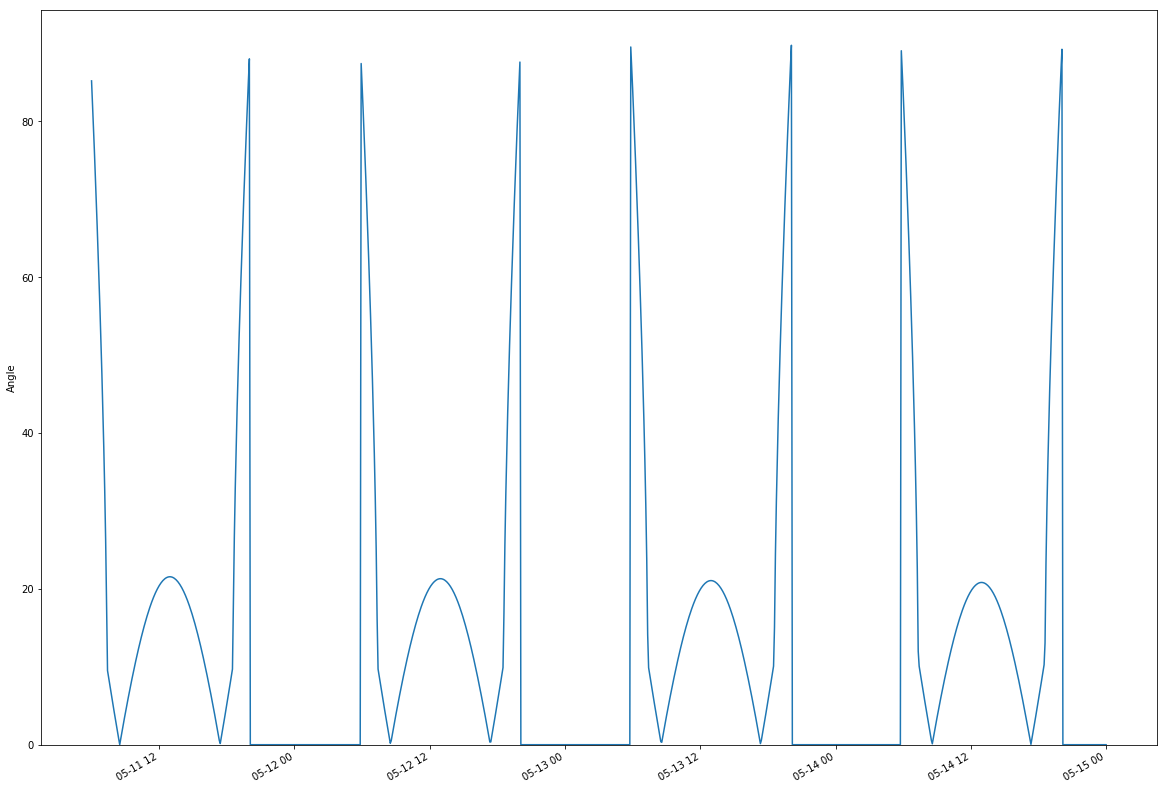

In [17]:
# ModelChain sotres modeling results on a series of attributes. 
# Angle of Incidence
mc.aoi.fillna(0).plot(figsize=(20,15));
plt.ylim(0, None);
plt.ylabel('Angle');

## Modeling intermediates & Forecast power

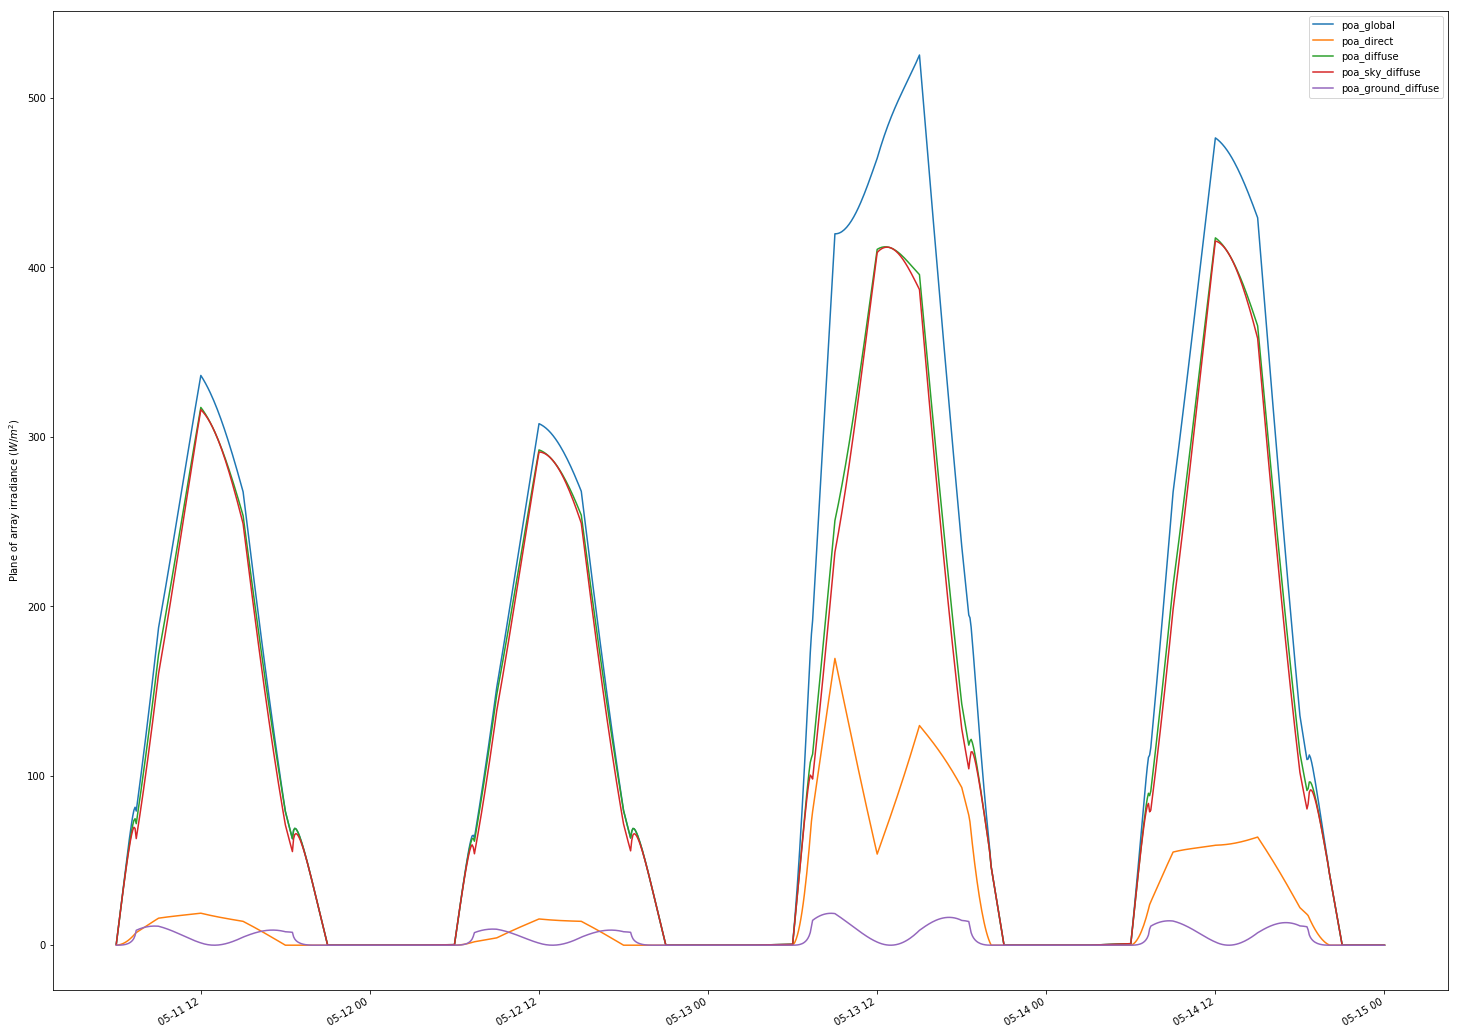

In [18]:
mc.total_irrad.plot(figsize=(25,20));
plt.ylabel('Plane of array irradiance ($W/m^2$)');
plt.legend(loc='best');

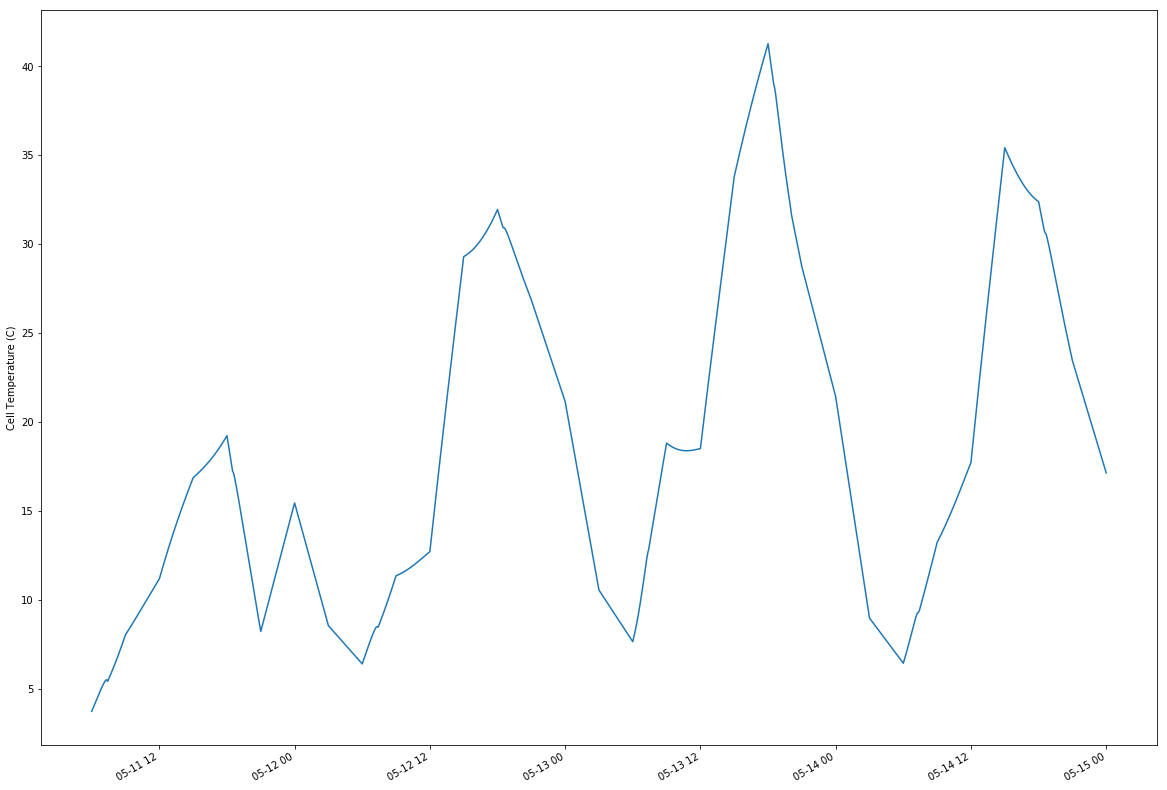

In [19]:
# Cell and module temperature
mc.cell_temperature.plot(figsize=(20,15));
plt.ylabel('Cell Temperature (C)');

## MC DC Power

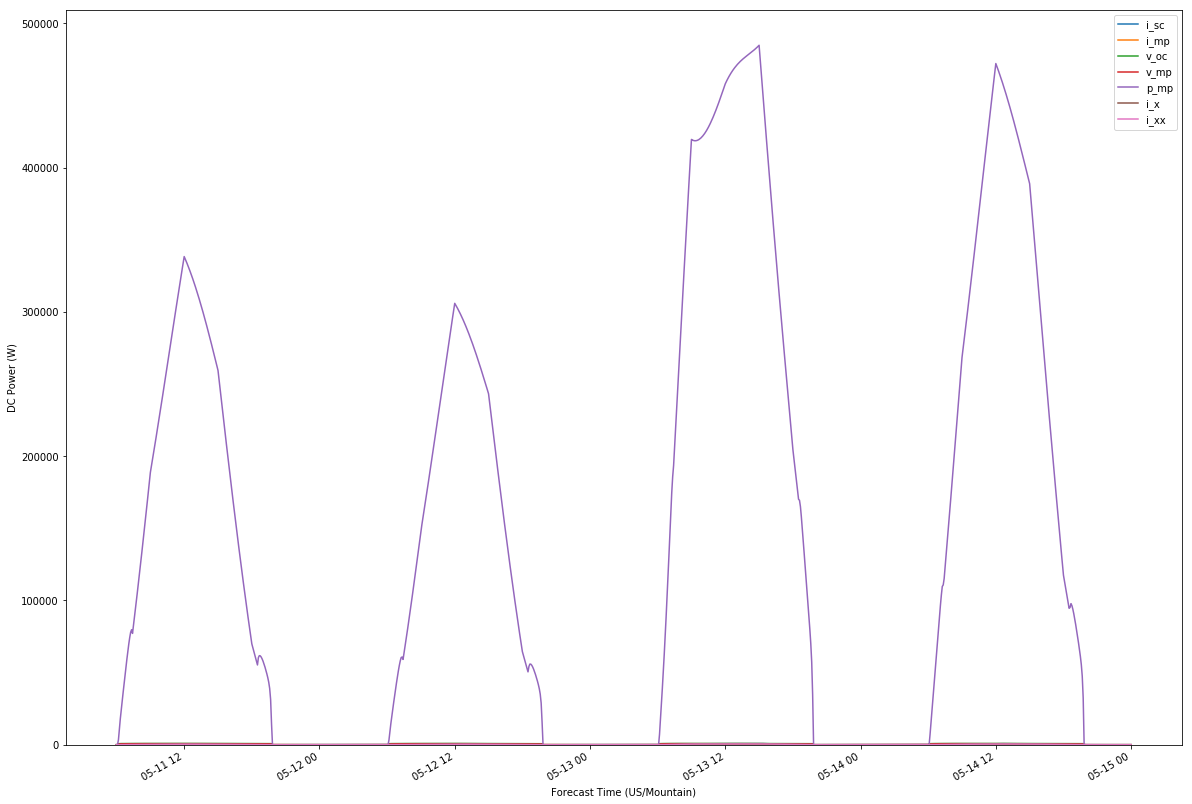

In [20]:
mc.dc.fillna(0).plot(figsize=(20,15));
plt.ylim(0, None);
plt.ylabel('DC Power (W)');
plt.xlabel('Forecast Time ({})'.format(tz));

In [21]:
mc.dc.describe()

,i_sc,i_mp,v_oc,v_mp,p_mp,i_x,i_xx
count,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000
mean,366.635762,330.454481,791.896930,651.236373,230048.977779,357.487517,253.530040
std,222.465280,199.900617,161.039870,142.140692,144052.946151,217.049273,150.087485
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,173.137500,156.593263,783.023368,634.548881,99236.694394,168.687963,123.350130
50%,364.521544,328.310305,831.680331,690.180797,229163.266024,355.311221,255.284018
75%,519.227543,467.320426,861.534580,724.524368,332881.876686,506.291692,358.492134
max,797.649827,715.314960,879.284342,743.303809,484849.510452,778.278517,536.691896


In [22]:
mc.dc.fillna(0)

,i_sc,i_mp,v_oc,v_mp,p_mp,i_x,i_xx
2020-05-11 06:00:00-06:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-05-11 06:05:00-06:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-05-11 06:10:00-06:00,8.711410,7.914486,708.405851,417.749839,3306.275154,8.484275,6.297563
2020-05-11 06:15:00-06:00,22.734997,20.652198,754.193702,535.173366,11052.506543,22.142952,16.414874
2020-05-11 06:20:00-06:00,34.174603,31.039970,773.373785,578.228650,17948.200210,33.285554,24.649269
2020-05-11 06:25:00-06:00,44.251364,40.187947,785.361367,603.319442,24246.170026,43.101192,31.888749
2020-05-11 06:30:00-06:00,53.706247,48.769416,794.228949,620.972741,30284.477640,52.311490,38.669597
2020-05-11 06:35:00-06:00,62.866762,57.081912,801.357519,634.595208,36223.907824,61.235425,45.228387
2020-05-11 06:40:00-06:00,71.845791,65.228017,807.335706,645.621514,42112.611085,69.982936,51.646785
2020-05-11 06:45:00-06:00,80.655879,73.219213,812.462175,654.783142,47942.706063,78.566219,57.934365


In [23]:
mc.dc.fillna(0).to_csv('5 min DC.csv', encoding='utf-8')

## MC AC Power

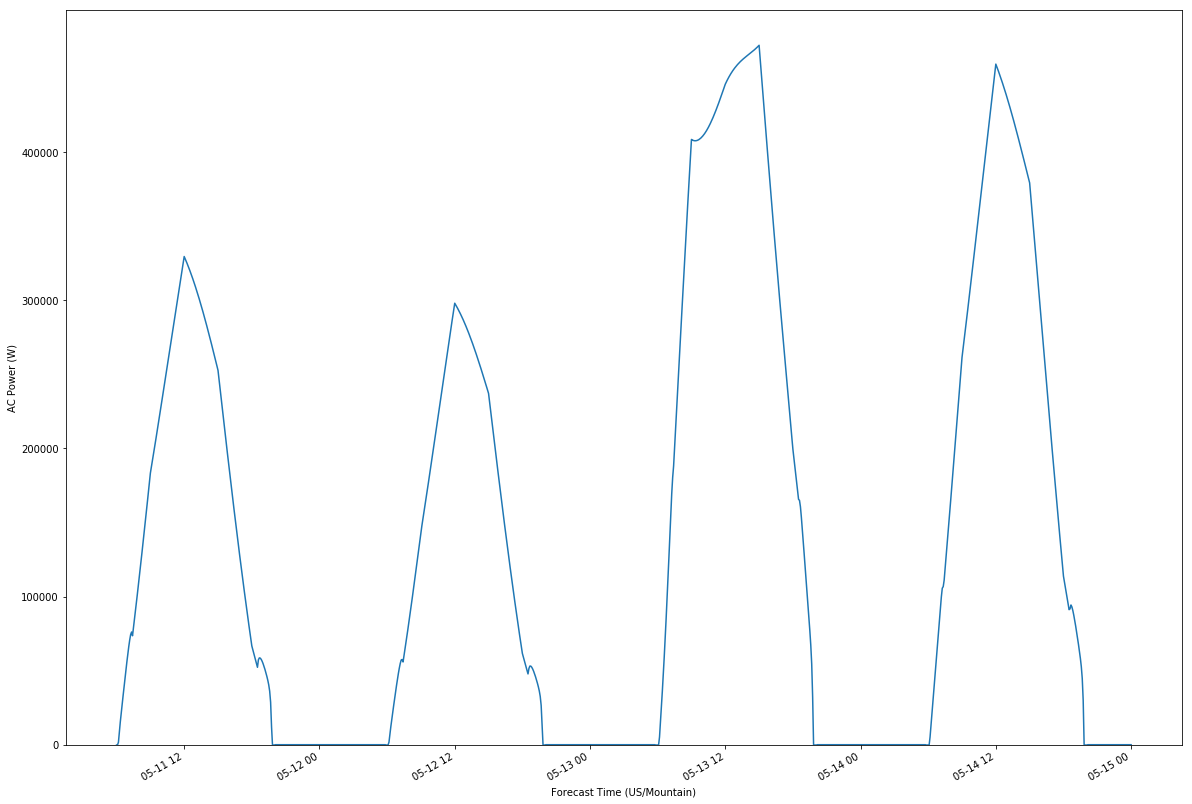

In [24]:
# AC Power
mc.ac.fillna(0).plot(figsize=(20,15));
plt.ylim(0, None);
plt.ylabel('AC Power (W)');
plt.xlabel('Forecast Time ({})'.format(tz));

In [25]:
mc.ac.describe()

count       683.000000
mean     223663.803751
std      140797.380714
min        -195.900000
25%       95360.194326
50%      222966.808778
75%      324277.921495
max      472221.037426
dtype: float64

In [26]:
mc.ac.fillna(0)

2020-05-11 06:00:00-06:00      -195.900000
2020-05-11 06:05:00-06:00      -195.900000
2020-05-11 06:10:00-06:00      1636.008323
2020-05-11 06:15:00-06:00      8787.016649
2020-05-11 06:20:00-06:00     15431.983033
2020-05-11 06:25:00-06:00     21563.781262
2020-05-11 06:30:00-06:00     27469.944563
2020-05-11 06:35:00-06:00     33294.473164
2020-05-11 06:40:00-06:00     39078.598217
2020-05-11 06:45:00-06:00     44811.217523
2020-05-11 06:50:00-06:00     50455.185782
2020-05-11 06:55:00-06:00     55956.608072
2020-05-11 07:00:00-06:00     61242.882896
2020-05-11 07:05:00-06:00     66209.263200
2020-05-11 07:10:00-06:00     70683.238219
2020-05-11 07:15:00-06:00     74318.526332
2020-05-11 07:20:00-06:00     76086.081243
2020-05-11 07:25:00-06:00     73562.769458
2020-05-11 07:30:00-06:00     78912.234860
2020-05-11 07:35:00-06:00     84315.320849
2020-05-11 07:40:00-06:00     89770.693429
2020-05-11 07:45:00-06:00     95277.315246
2020-05-11 07:50:00-06:00    100834.372401
2020-05-11 

In [27]:
mc.ac.fillna(0).to_csv('5 min AC.csv', encoding='utf-8')